# Ultimate Data Science Challenge Part 3
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

# DATA CLEANING, EDA, VISUALIZATION¶

In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#load data and visualize
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [3]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


## Frist Impressions
First impressions are that the users will need to be labled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. While the reason for the missing ratings cannot be inferred, it seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the mean value so as to not affect the current distribution, which is primarily high ratings.

In [4]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

## Set Target Variable
The target variable will be whether the user was active in the sixth month from January (June). Convert the signup date and last trip date to datetime objects then encode each user active in June as True, else False

In [6]:
#set as datatime objects
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

In [7]:
#encode target variable 'active' as true or false for last trip in june
df['active'] = [1 if x.month >= 6 else 0 for x in df.last_trip_date]
#encode ultimate_black_user as categorical 
df['ultimate_black_user'] = [1 if x == True else 0 for x in df.ultimate_black_user]
df = df.drop(['last_trip_date', 'signup_date'], axis =1)

## What is the ratio of Active Users to Inactive Users?

Percent of Active Users: 0.37608


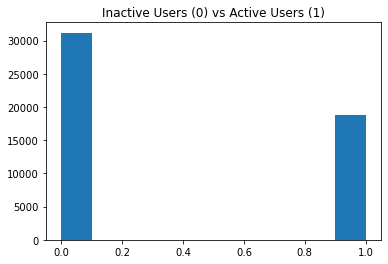

In [8]:
plt.hist(df.active)
plt.title('Inactive Users (0) vs Active Users (1)')
plt.show
print('Percent of Active Users: {}'.format(sum(df.active)/len(df.active))) #calculate ratio of active to inactive users

Unsurprisingly the classes are imbalanced, but not tremendously. This should not present too much of a problem while modeling.

## Picking a Model
Based on the size, variables, and relationship b/w those variables, an appropriate model can be selected to describe this data set. A pairplot can help summarize the variables relationships between each other.

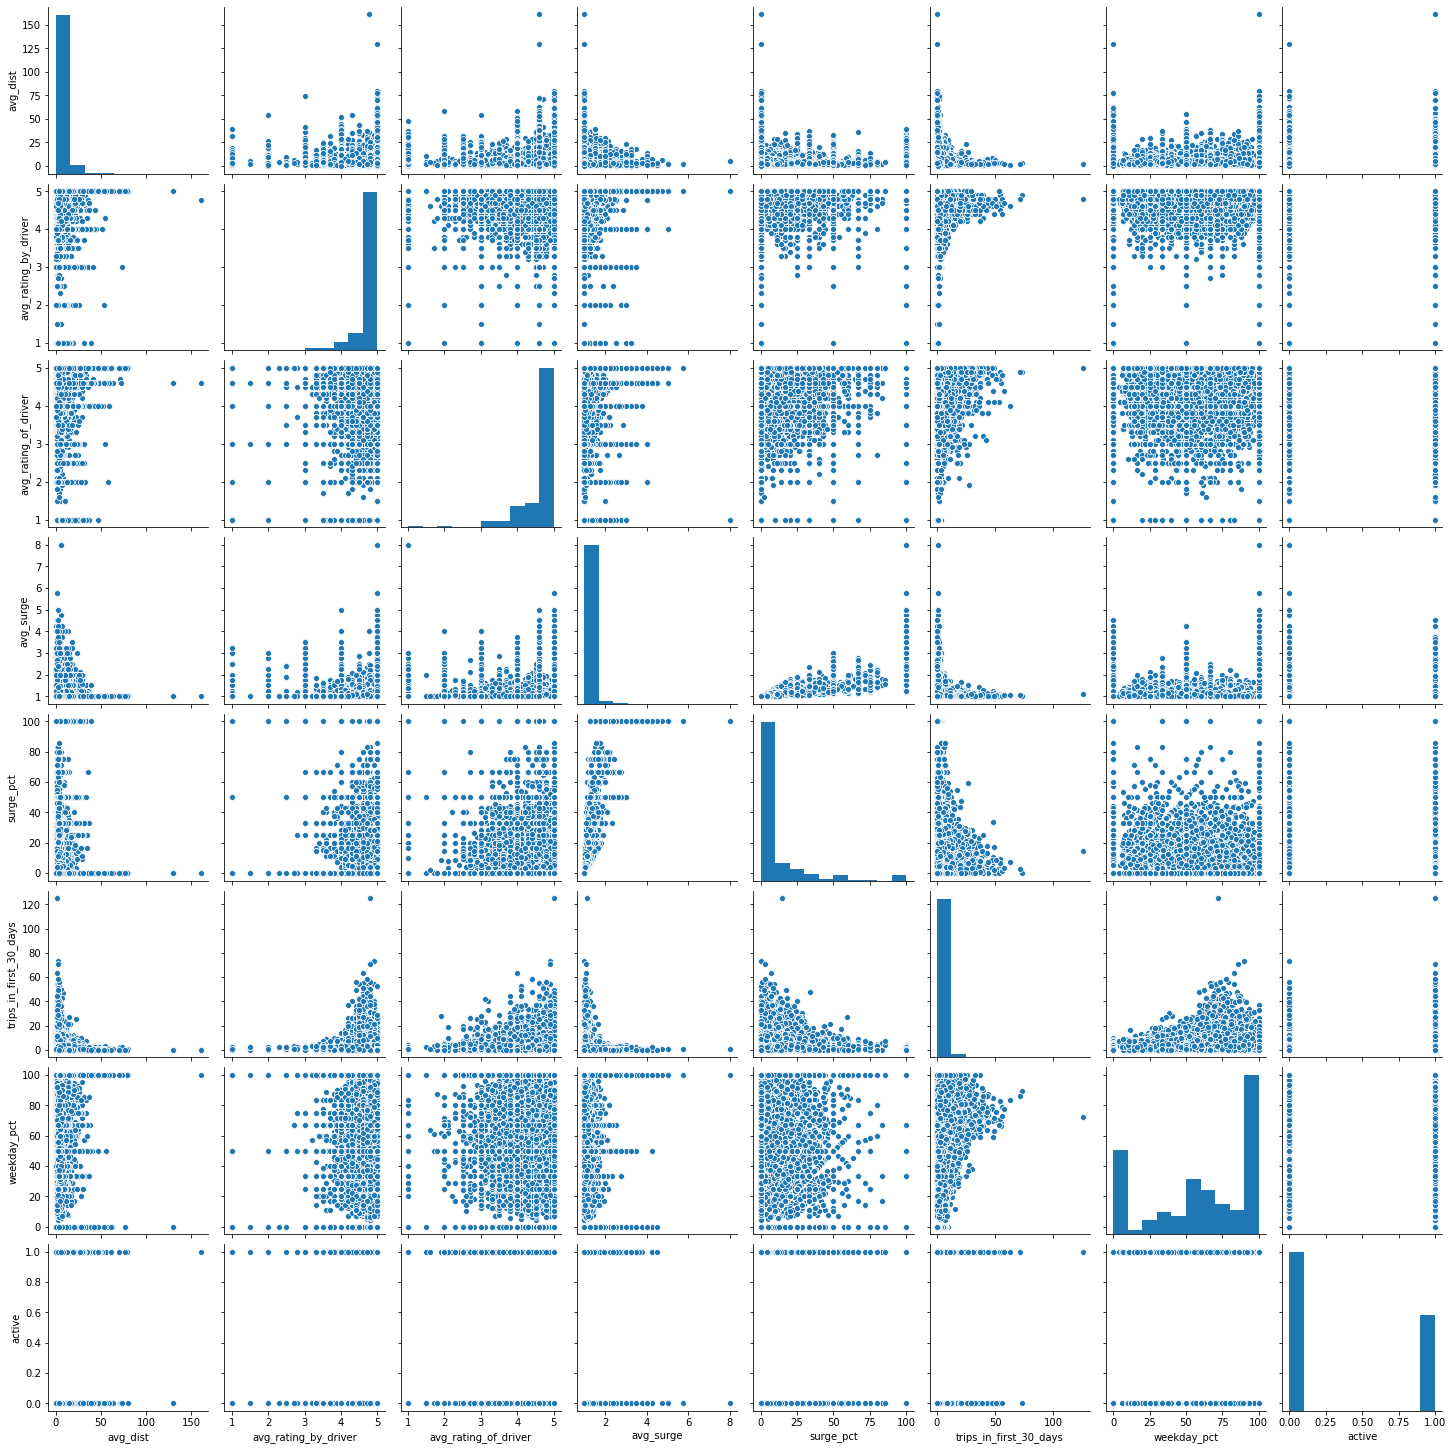

In [9]:
#select out only continuous variables
df_pp = df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
           'surge_pct', 'trips_in_first_30_days', 'weekday_pct', 'active']]
#plot
sns.pairplot(df_pp)

From this it is apparent that some of the variables correlate with one another. This makes using a linear model an unlikely choice, since those assume that the variables are independent. This leaves us with the choice of a SVC, Kneighbors, and RandomForestClassifier. SVC fairs better with higher dimensional data, while RandomForestClassifier is susceptible to high levels of noise (of which there appears to be a lot), so for this data the first choice will be Kneighbors.

## Encoding Discrete Variables
Discrete Variables must be encoded in order to work with continuous data for Kneighbors. To make this work, only pd.get_dummies is necessary.

In [10]:
df = pd.get_dummies(df)
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


## PREDICTIVE MODELING
Generally speaking Kneighbors is not the best algorithm for prediciton, but it fits the needs of this data set, and will be easy to interpret when the time comes. Begin by splitting into train and test sets and normalize both seperately.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#seperate data and labels
data = df.drop('active', axis=1)
labels = df.active

#split .33 to .67
X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

#normalize both sets post-split
X_train = normalize(X_train)
y_train = normalize(y_train)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

#lets try the out of the box classifier with 10 neighbors
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, X_test)

#test the accuracy
knn.score(y_train, y_test)

0.7476363636363637

This is fairly promising to see from an out of the box classifier. This accuracy is about equivalent to rolling a 4 sided dice with 3/4 positive outcomes. Next step is to cross-validate the model and tune its parameters, which can be done in a single step.

In [13]:
from sklearn.model_selection import GridSearchCV

#specify a parameter grid to search over
parameters = {
    'n_neighbors': [10, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn_cv = GridSearchCV(knn, parameters, cv=5) #specify GridSearchCV object

knn_cv.fit(X_train, X_test) #fit to training data

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=10),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [10, 13, 15],
                         'weights': ['uniform', 'distance']})

In [14]:
#find classifiers best parameters
knn_cv.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}

So far the manhattan distance with 13 neighbors and uniform weighting are the best options.

In [15]:
#check for accuracy improvement
knn_cv.score(y_train, y_test)

0.7587878787878788

And cross validation managed to squeeze an extra percent out of the test data, which is quite good.

## Model Performance
The bottom line here is: Was the model useful? First check some of the critical metrics

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

#predict classifications
y_pred = knn_cv.predict(y_train)

print(classification_report(y_test, y_pred)) # print classification report and confusion matrix

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81     10305
           1       0.71      0.61      0.66      6195

    accuracy                           0.76     16500
   macro avg       0.75      0.73      0.74     16500
weighted avg       0.75      0.76      0.75     16500

confusion matrix:
[[8720 1585]
 [2395 3800]]


Based on the matrix above, it is clear that the model is much better at predicting a user who will go inactive over a user who will remain active in their sixth month. This is likely due to the class support and less likely due to the intrinsic value of the data. The reason I say that is because the percision of the 'active' predictions is fairly high, but recall is suffering because the model is failing to notice preditive features of the 'active' class. For a better idea of the overall performace of the model, refer to the ROC curve below.

C:\Users\opa\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


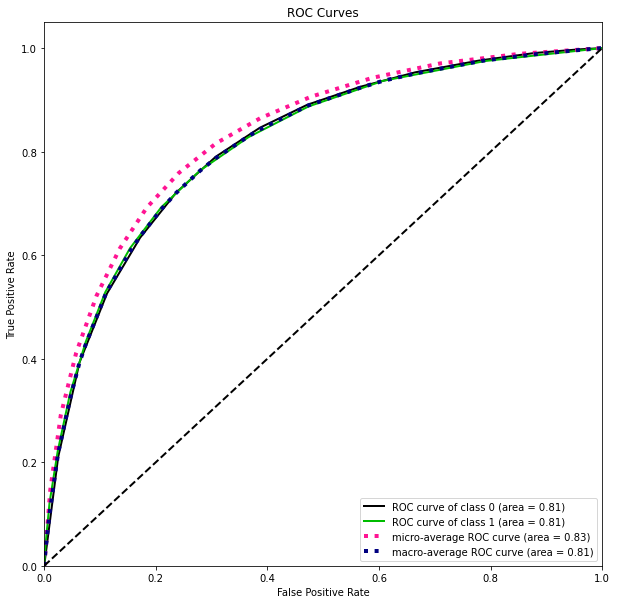

AUC score: 0.7297945354343844


In [18]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score

#plot roc curve and  print AUV score
y_probas = knn_cv.predict_proba(y_train)
skplt.metrics.plot_roc_curve(y_test, y_probas, figsize=(10,10))
plt.show()
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))

What this curve visualizes, and the AUC score indicates, is that this model is about 25% better than flipping a coin at random in terms of predicting whether users will be active in the 6th month. Again, that is about the odds of rolling a 4-sided dice with 3/4 positive outcomes (or a 1 in 4 chance on average that it will be wrong). Of course that is not to ignore the fact that the f1-score for predicting an active user was merely 66% which is only 16% higher than random guessing.

## IMPLICATIONS:
One might think "16% better than guessing is not very useful nor helpful" but that depends on how you frame the problem. For instance, one might benefit from asking the question "do I want to know for sure that a user will be active in 6 months, or do I want to know for sure that a user will be inactive in 6 months?" In other words, it might be more helpful to know why users are leaving than why they are staying. By exploring the implications of the model, that question might be reasonably answered.

## Feature Importance
By using cross-validation and testing each feature individually, each individual feature can be observed for its effect on the model performance.

In [20]:
from sklearn.model_selection import cross_val_score

#instate a new classifier 

#to be used as index for feature number
n_feats = data.shape[1]

#loop over each feature, cross validate and print score
print('Feature  Accuracy')
for i in range(n_feats):
    X = data.iloc[:, i].values.reshape(-1, 1)
    knn_feat_test = KNeighborsClassifier(n_neighbors=13, weights='uniform', metric='manhattan')
    scores = cross_val_score(knn_feat_test, X, labels)
    print('%d        %g' % (i, scores.mean()))

Feature  Accuracy
0        0.63902
1        0.68226
2        0.70436
3        0.71518
4        0.62362
5        0.72672
6        0.59282
7        0.7067
8        0.57282
9        0.67584
10        0.53038
11        0.62392
12        0.59754


So thanks to cross-validation it is apparent that the main features of this data set (in terms of the target variable) are feature 3, 4, and 7 (avg_surge, surge_pct, and weekday_pct). Looking at these variables in terms of the target variable might reveal details about users who remain active.

Text(0.5, 1.0, 'weekday_pct for users active @ 6 months')

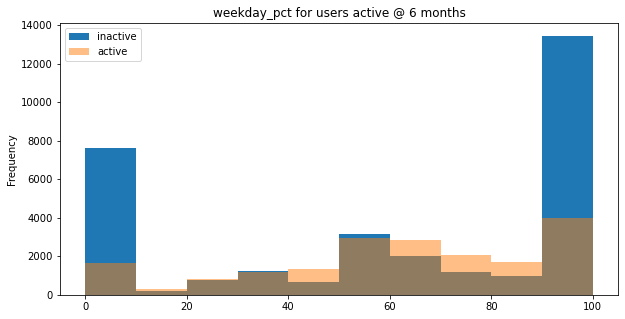

In [21]:
#subset active and inactive users for feature 7
feat_7_active = df.weekday_pct.loc[df['active'] == 1]
feat_7_inactive = df.weekday_pct.loc[df['active'] == 0]

plt.figure(figsize=(10,5))

#plot
feat_7_inactive.plot(kind='hist')
feat_7_active.plot(kind='hist', alpha=0.5)
plt.legend(['inactive', 'active'])
plt.title('weekday_pct for users active @ 6 months')

For both classes, there are users who ride exclusively during the weekdays or during the weekends, but a mix of both was a better marker for users who will be active @ 6 months. Since the model recognized users who became inactive @ 6 months, it is likely that being an exclusive weekender or exclusive weekdayer is a strong marker of potential user loss. The same breakdown for features 3 and 4 are below, but without a more in-depth explaination about their meaning, I cannot offer an decent explaination for their effect on model.

Features 3 and 4 (ave_surge and surge_pct) are harder to interpret. Since I don't understand their meaning in context to the data I cannot comment on their exact implications for the model.